# Run just the linear regression, as a benchmark

We will run just the linear regression, against each of the created pre-processed data sets.

### let's take care of the imports/functions to get running...

In [78]:

import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.externals import joblib

import itertools

import matplotlib.pyplot as plt
from IPython.display import display, Image

from subprocess import check_output
datadir="./input/"
cachedir="./cache/"
outdir='./output/'

print(check_output(["ls", datadir]).decode("utf8"))
print(check_output(["ls", cachedir]).decode("utf8"))
print(check_output(["ls", outdir]).decode("utf8"))

%matplotlib inline  

test.csv
test.csv.zip
test_data_all_features.csv
test_data_cats.csv
test_data_conts.csv
test_data_new.csv
test_data_orig_only.csv
train.csv
train.csv.zip
train_data_all_features.csv
train_data_cats.csv
train_data_conts.csv
train_data_new.csv
train_data_orig_only.csv

clusters_cat.npy
clusters_cat.npy_01.npy
clusters_cat.npy_02.npy
clusters_cont.npy
clusters_cont.npy_01.npy
clusters_cont.npy_02.npy
clusters.npy
clusters.npy_01.npy
clusters.npy_02.npy
grid_L2_KNN.pkl
grid_L2_Lin.pkl
grid_regr0.pkl
grid_regr1.pkl
grid_regr2.pkl
grid_regr3.pkl
MAE_tracking.npy
oldmodels
x_layer2.npy
x_layer2.npy_01.npy
x_layer2_w_clusters.npy
x_layer2_w_clusters.npy_01.npy

result_submission_all_features_linear.csv
result_submission_cats_linear.csv
result_submission_conts_linear.csv
result_submission_new_linear.csv
result_submission_orig_only_linear.csv
result_submission_stack_linear.csv
result_submission_stack_xgb.csv



In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [3]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(cachedir+filename):
        print filename," exists, importing "
        return joblib.load(cachedir+filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        print("debug 1")
        grid_search.fit(x,y)
        print "debug2"
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,cachedir+filename) 
    return regr

In [15]:
def prepdata(data_name,verbose=False):
    ### and now, let's import the data
    data = loadData(datadir,'train_data_'+data_name+'.csv')
    if verbose==True:
        display(data.info())
        display(data.head(2))

    test_data= loadData(datadir,'test_data_'+data_name+'.csv') 
    if verbose==True:
        display(test_data.info())
        display(test_data.head(2))
    # we don't want the ID columns in X
    x=data.drop(['id','loss'],1).values
    # loss is our label
    #y=data['loss'].values
    y = np.log(data['loss']+shift).ravel()

    return x,y,test_data




In [65]:
  def predict_for_dataset(data_name):
    
    #for the current data, load and prep     
    x,y,test_data=prepdata(data_name)
    
    #  train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split( x,
                                                                    y,
                                                                   test_size=0.20,
                                                                    random_state=42)
    display("sample train data size:{}".format(len(y_train)))

    #set up our regression
    estimator=LinearRegression(n_jobs=-1)
    
    #train the estimator
    start_time = time.time()
    estimator.fit(X_train,y_train)
    fit_time=time.time()-start_time
    
    #test on the validation set
    start_time = time.time()
    curr_predict=np.array(estimator.predict(X_validation)).copy()
    predict_time=time.time()-start_time

    #track the run info
    MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_validation)))

    #show some stats on that last regressions run
    print("\nfit time:{}s".format(round(fit_time, 3) ))
    print("Mean abs error: {:.2f}".format(MAE))
    print("predict time:{}s".format(round(predict_time, 3) ))
    
    #retrain on all the data for predicting the test set
    start_time = time.time()
    estimator.fit(x,y)
    final_fit_time=time.time()-start_time

    #the Final Prediction on the test data
    x_test_data=test_data.drop(['loss','id'],1) .values# didn't have the loss column before, make it go away! don't need ID!
    
    start_time = time.time()
    test_data['loss']=np.exp(estimator.predict(x_test_data))-shift
    final_predict_time=time.time()-start_time
    del x_test_data

    result=test_data[['id','loss',]]
    output_fname='result_submission_'+data_name+'_linear.csv'
    print("\nFinal predict time:{}\nfinal sample".format(final_predict_time))
    display(writeData(result,outdir+output_fname))
    return [data_name,MAE,fit_time,predict_time,final_fit_time,final_predict_time]



In [66]:
stat_tracking=[] # to hold the returned stats from each run
shift=200
data_names=['new','conts','cats','orig_only','all_features'] # the name of each data set from preprocess
for data_name in data_names:
    # Train and predict on validataion set, then again on test set.
    stat_tracking.append(predict_for_dataset(data_name))


loading: ./input/train_data_all_features.csv
Dataset has 188318 samples with 135 features each.
loading: ./input/test_data_all_features.csv
Dataset has 125546 samples with 135 features each.


'sample train data size:150654'


fit time:5.451s
Mean abs error: 1276.01
predict time:0.012s

Final predict time:0.0966310501099
final sample


['id,loss\n',
 '4,1374.45537539\n',
 '6,1843.67823927\n',
 '9,12789.3271178\n',
 '12,4513.51479623\n']

loading: ./input/train_data_orig_only.csv
Dataset has 188318 samples with 132 features each.
loading: ./input/test_data_orig_only.csv
Dataset has 125546 samples with 132 features each.


'sample train data size:150654'


fit time:5.945s
Mean abs error: 1277.38
predict time:0.014s

Final predict time:0.0996148586273
final sample


['id,loss\n',
 '4,1396.61752665\n',
 '6,1821.95328877\n',
 '9,12825.9715076\n',
 '12,4532.90009162\n']

loading: ./input/train_data_new.csv
Dataset has 188318 samples with 5 features each.
loading: ./input/test_data_new.csv
Dataset has 125546 samples with 5 features each.


'sample train data size:150654'


fit time:0.017s
Mean abs error: 1797.68
predict time:0.001s

Final predict time:0.00564002990723
final sample


['id,loss\n',
 '4,2131.26566595\n',
 '6,2356.8063542\n',
 '9,2164.22158207\n',
 '12,2102.76094405\n']

loading: ./input/train_data_conts.csv
Dataset has 188318 samples with 16 features each.
loading: ./input/test_data_conts.csv
Dataset has 125546 samples with 16 features each.


'sample train data size:150654'


fit time:0.179s
Mean abs error: 1792.47
predict time:0.003s

Final predict time:0.0298418998718
final sample


['id,loss\n',
 '4,1959.16236284\n',
 '6,2269.56077302\n',
 '9,2407.42519088\n',
 '12,2350.71821889\n']

loading: ./input/train_data_cats.csv
Dataset has 188318 samples with 118 features each.
loading: ./input/test_data_cats.csv
Dataset has 125546 samples with 118 features each.


'sample train data size:150654'


fit time:5.447s
Mean abs error: 1289.14
predict time:0.012s

Final predict time:0.0832099914551
final sample


['id,loss\n',
 '4,1598.78955834\n',
 '6,1892.83552099\n',
 '9,11804.3214499\n',
 '12,4425.90920497\n']

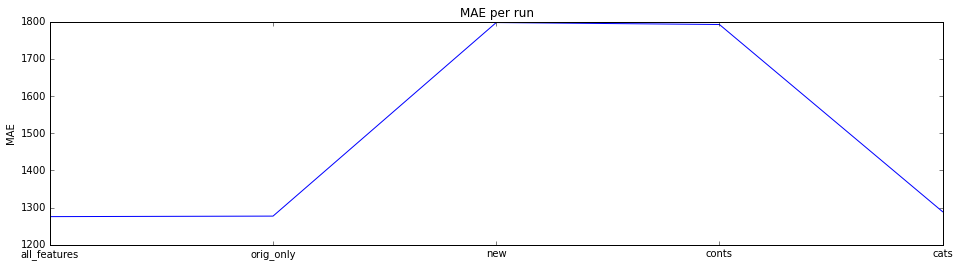

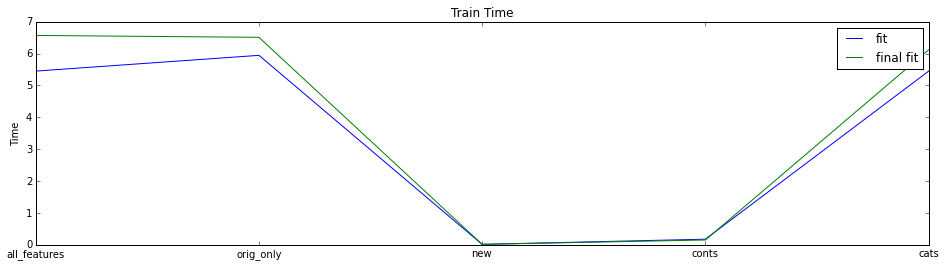

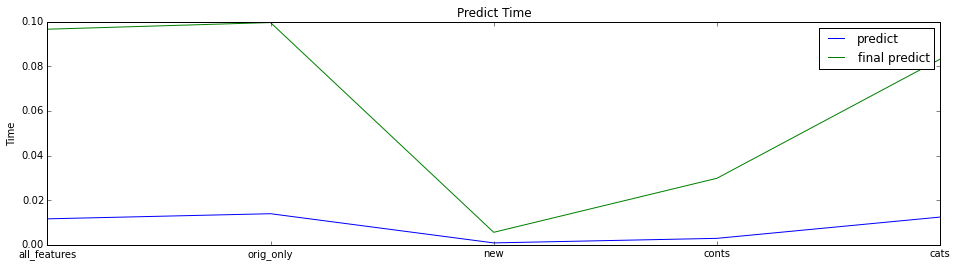

['./cache/stat_tracking-Linear.npy']

In [79]:

#display(stat_tracking)
run=[]
MAEs=[]
fit_times=[]
predict_times=[]
final_fit_time=[]
final_pred_times=[]
for stat in stat_tracking:
    run.append(stat[0])
    MAEs.append(stat[1])
    fit_times.append(stat[2])
    predict_times.append(stat[3])
    final_fit_time.append(stat[4])
    final_pred_times.append(stat[5])
    
plt.figure(figsize=(16,4))
plt.plot(MAEs)
plt.xticks(range(len(run)), run)
plt.ylabel('MAE')
plt.title('MAE per run')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(fit_times,label='fit')
plt.plot(final_fit_time,label='final fit')
plt.xticks(range(len(run)), run )
plt.ylabel('Time')
plt.title('Train Time')
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.plot(predict_times,label='predict')
plt.plot(final_pred_times,label='final predict')
plt.xticks(range(len(run)), run )
plt.ylabel('Time')
plt.title('Predict Time')
plt.legend()
plt.show()

joblib.dump(stat_tracking,cachedir+'stat_tracking-Linear.npy')

### EOL